<a href="https://colab.research.google.com/github/arpitsolanki/FPLBot/blob/main/Fantasy_League.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import requests
import json
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import xgboost as xgboost

from sklearn.model_selection import train_test_split #Splitting data for model training
from sklearn.ensemble import RandomForestClassifier #RF
from sklearn.preprocessing import LabelEncoder#Label Encoder
from sklearn.preprocessing import OneHotEncoder#One Hot Encoder
from sklearn.metrics import confusion_matrix#Confusion Matrix
from sklearn.metrics import roc_curve#RoC Curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve#Metrics Functions


In [2]:
#Fantasy API Calls to pull historic player stats
url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
response = requests.get(url)
response = json.loads(response.content)

#Fixtures for upcoming game weeks
fix_url = 'https://fantasy.premierleague.com/api/fixtures?event=15'
fix_response = requests.get(fix_url)
fix_response = json.loads(fix_response.content)

In [3]:
def get(url):
    response = requests.get(url)
    return json.loads(response.content)
                      

In [4]:
players = response['elements']
teams = response['teams']
events = response['events']
#fixtures = fix_response['fixtures']

players_df = pd.DataFrame(players)
teams_df = pd.DataFrame(teams)
events_df = pd.DataFrame(events)
fixtures_df=pd.DataFrame(fix_response)
fixtures_df


,code,event,finished,finished_provisional,id,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id
0,2128430,15,False,False,143,2020-12-26T12:30:00Z,0,False,False,13,None,9,None,[],4,4,59040
1,2128427,15,False,False,140,2020-12-26T15:00:00Z,0,False,False,6,None,2,None,[],3,3,59037
2,2128428,15,False,False,141,2020-12-26T15:00:00Z,0,False,False,16,None,8,None,[],3,2,59038
3,2128426,15,False,False,139,2020-12-26T17:30:00Z,0,False,False,5,None,1,None,[],4,3,59036
4,2128432,15,False,False,145,2020-12-26T20:00:00Z,0,False,False,14,None,12,None,[],2,5,59042
5,2128433,15,False,False,146,2020-12-26T20:00:00Z,0,False,False,7,None,15,None,[],3,2,59043
6,2128429,15,False,False,142,2020-12-27T12:00:00Z,0,False,False,4,None,10,None,[],2,3,59039
7,2128434,15,False,False,147,2020-12-27T14:15:00Z,0,False,False,3,None,19,None,[],2,3,59044
8,2128431,15,False,False,144,2020-12-27T16:30:00Z,0,False,False,18,None,11,None,[],2,5,59041
9,2128435,15,False,False,148,2020-12-27T19:15:00Z,0,False,False,17,None,20,None,[],4,3,59045


In [5]:
#Dataset from Fivethirtyeight providing projected scores for the upcoming game week
spi_data = pd.read_csv('https://projects.fivethirtyeight.com/soccer-api/club/spi_matches_latest.csv')
spi_data=spi_data.loc[(spi_data['season']==2020) & (spi_data['league']=='Barclays Premier League')]
#spi_data

#Team mapping file
team_mapping_spi=pd.read_csv('https://raw.githubusercontent.com/arpitsolanki/FPLBot/main/team_mapping.csv')
#team_mapping_spi

#Add team_ids to the 538 dataset to make it compatible with FPL API datasets
spi_data_name=pd.merge(left=spi_data,right=team_mapping_spi,how='inner',left_on='team1',right_on='team')
spi_data_name=spi_data_name.rename(columns={"id": "team1_id"})

spi_data_name=pd.merge(left=spi_data_name,right=team_mapping_spi,how='inner',left_on='team2',right_on='team')
spi_data_name=spi_data_name.rename(columns={"id": "team2_id"})
#spi_data_name

In [6]:
#players_df

In [7]:
players_df_filtered=players_df[['web_name','element_type','now_cost','selected_by_percent','points_per_game','team','total_points','minutes','goals_scored','assists','clean_sheets','goals_conceded','yellow_cards','red_cards','bonus','chance_of_playing_next_round']]
players_df_filtered=players_df_filtered.loc[players_df_filtered['minutes']>100]
players_df_filtered['now_cost_mil']=players_df_filtered['now_cost']/10
players_df_filtered['ppm']=players_df_filtered['total_points']/players_df_filtered['now_cost_mil']
players_df_filtered.sort_values(by='ppm',ascending=False,inplace=True)


In [8]:
#players_df_filtered.sort_values(by='total_points',ascending=False)


In [9]:
teams_df_filtered=teams_df[['id','name','short_name','played','points','position','win','draw','loss']]
teams_df_filtered_join=teams_df[['id','name']]


In [10]:
fixtures_df_name=pd.merge(left=fixtures_df,right=teams_df_filtered_join,left_on='team_a',right_on='id',how='left')
fixtures_df_name=fixtures_df_name.rename(columns={"name": "away_team"})
fixtures_df_name=pd.merge(left=fixtures_df_name,right=teams_df_filtered_join,left_on='team_h',right_on='id',how='left')
fixtures_df_name=fixtures_df_name.rename(columns={"name": "home_team"})
fixtures_df_name

,code,event,finished,finished_provisional,id_x,kickoff_time,minutes,provisional_start_time,started,team_a,team_a_score,team_h,team_h_score,stats,team_h_difficulty,team_a_difficulty,pulse_id,id_y,away_team,id,home_team
0,2128430,15,False,False,143,2020-12-26T12:30:00Z,0,False,False,13,None,9,None,[],4,4,59040,13,Man Utd,9,Leicester
1,2128427,15,False,False,140,2020-12-26T15:00:00Z,0,False,False,6,None,2,None,[],3,3,59037,6,Crystal Palace,2,Aston Villa
2,2128428,15,False,False,141,2020-12-26T15:00:00Z,0,False,False,16,None,8,None,[],3,2,59038,16,Southampton,8,Fulham
3,2128426,15,False,False,139,2020-12-26T17:30:00Z,0,False,False,5,None,1,None,[],4,3,59036,5,Chelsea,1,Arsenal
4,2128432,15,False,False,145,2020-12-26T20:00:00Z,0,False,False,14,None,12,None,[],2,5,59042,14,Newcastle,12,Man City
5,2128433,15,False,False,146,2020-12-26T20:00:00Z,0,False,False,7,None,15,None,[],3,2,59043,7,Everton,15,Sheffield Utd
6,2128429,15,False,False,142,2020-12-27T12:00:00Z,0,False,False,4,None,10,None,[],2,3,59039,4,Burnley,10,Leeds
7,2128434,15,False,False,147,2020-12-27T14:15:00Z,0,False,False,3,None,19,None,[],2,3,59044,3,Brighton,19,West Ham
8,2128431,15,False,False,144,2020-12-27T16:30:00Z,0,False,False,18,None,11,None,[],2,5,59041,18,West Brom,11,Liverpool
9,2128435,15,False,False,148,2020-12-27T19:15:00Z,0,False,False,17,None,20,None,[],4,3,59045,17,Spurs,20,Wolves


In [11]:
df_l=[]
for i in range(15):
  fix_url = 'https://fantasy.premierleague.com/api/fixtures?event='+str(i+1)
  fix_response = requests.get(fix_url)
  fix_response = json.loads(fix_response.content)
  fixtures_df=pd.DataFrame(fix_response)
  fixtures_df['gw']=i+1
  df_l.append(fixtures_df)
#  print(fix_url)

fixtures_df = pd.concat(df_l, axis=0, ignore_index=True)
fixtures_df_map=fixtures_df[['gw','kickoff_time']].copy()

fixtures_df_map['date']=pd.to_datetime(fixtures_df_map['kickoff_time'], errors='coerce').dt.date

del fixtures_df_map['kickoff_time']
fixtures_df_map=fixtures_df_map.drop_duplicates()
#fixtures_df_map

In [12]:
fixtures_df_name_cur_gw=fixtures_df_name[['home_team','away_team','id','id_y']]
fixtures_df_name_cur_gw.columns=['home_team','away_team','home_id','away_id']



In [13]:
spi_data_name_fil=spi_data_name[['team1','team2','team1_id','team2_id','proj_score1','proj_score2']]
spi_data_name_fil.columns=['team1','team2','home_id','away_id','proj_score1','proj_score2']

spi_gw_scores=pd.merge(left=fixtures_df_name_cur_gw,right=spi_data_name_fil,left_on=['home_id','away_id'],right_on=['home_id','away_id'],how='inner')


In [14]:
players_df_filtered_teams=pd.merge(left=players_df_filtered,right=teams_df_filtered_join,how='inner',left_on='team',right_on='id')
#players_df_filtered_teams

In [15]:
#Read historical fixtures data
import datetime

team_list=['understat_Arsenal.csv','understat_Aston_Villa.csv','understat_Brighton.csv','understat_Burnley.csv','understat_Chelsea.csv','understat_Crystal_Palace.csv','understat_Everton.csv','understat_Fulham.csv','understat_Leeds.csv','understat_Leicester.csv','understat_Liverpool.csv','understat_Manchester_City.csv','understat_Manchester_United.csv','understat_Newcastle_United.csv','understat_Sheffield_United.csv','understat_Southampton.csv','understat_Tottenham.csv','understat_West_Bromwich_Albion.csv','understat_West_Ham.csv','understat_Wolverhampton_Wanderers.csv']
static='https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/understat/'
df_l=[]

for i in range(20):
  k=static+team_list[i]
  temp=pd.read_csv(k)
 # print(temp.shape[0])
  temp['team']=team_list[i]
  df_l.append(temp)

team_total_data = pd.concat(df_l, axis=0, ignore_index=True)

#team_total_data
#team_mapping_spi
team_total_data_id=pd.merge(left=team_total_data,right=team_mapping_spi,left_on='team',right_on='team_file_name',how='left')
team_total_data_id

team_total_data_id=team_total_data_id[['team_y','id','pts','date','h_a','xG','xGA','deep','deep_allowed','scored','missed']]
# #team_total_data_id
team_total_data_id['date_new']=pd.to_datetime(team_total_data_id['date'], errors='coerce').dt.date

del team_total_data_id['date']
team_total_data_id['cum_pts']=team_total_data_id.groupby(['team_y'])['pts'].cumsum()

#team_total_data_id

team_total_data_id_means = team_total_data_id.join(team_total_data_id.groupby(['id']).expanding().agg({'xG':'mean','xGA': 'mean', 'deep': 'mean', 'deep_allowed': 'mean','scored':'mean','missed':'mean'})
               .reset_index(level=0, drop=True)
               .add_suffix('_roll'))
team_total_data_id_means=team_total_data_id_means.groupby(['id', 'date_new']).last().reset_index()
team_total_data_id_means=team_total_data_id_means[['id','date_new','xG_roll','xGA_roll','deep_roll','deep_allowed_roll','scored_roll','missed_roll']]
team_total_data_id_means
#Create a league standings table
team_total_data_id=pd.merge(left=team_total_data_id,right=fixtures_df_map,left_on='date_new',right_on='date',how='inner')
team_total_data_id.sort_values(by='cum_pts',inplace=True,ascending=False)
team_total_data_id=team_total_data_id[['cum_pts','gw','id','date_new']]
team_total_data_id["rank"] = team_total_data_id.groupby("gw")["cum_pts"].rank("dense", ascending=False)
team_total_data_id.columns=['cum_pts','gw','id','date_new','rank']
#team_total_data_id

team_total_data_id=pd.merge(left=team_total_data_id,right=team_total_data_id_means,left_on=['id','date_new'],right_on=['id','date_new'],how='inner')
del team_total_data_id['date_new']
team_total_data_id['xG_diff']=team_total_data_id['xG_roll']-team_total_data_id['xGA_roll']
team_total_data_id['deep_diff']=team_total_data_id['deep_roll']/(team_total_data_id['deep_roll']+team_total_data_id['deep_allowed_roll'])
team_total_data_id['scored_diff']=team_total_data_id['scored_roll']/(team_total_data_id['scored_roll']+team_total_data_id['missed_roll'])
team_total_data_id=team_total_data_id[['cum_pts','gw','id','rank','xG_diff','deep_diff','scored_diff']]
team_total_data_id
#team_total_data_id.to_csv('team_total_data_id.csv')
#files.download('team_total_data_id.csv')


,cum_pts,gw,id,rank,xG_diff,deep_diff,scored_diff
0,31,14,11,1.0,0.756431,0.765854,0.654545
1,28,13,11,1.0,0.631564,0.770833,0.604167
2,27,14,9,2.0,0.288467,0.527607,0.604651
3,26,14,7,3.0,0.248913,0.427807,0.568182
4,26,14,13,3.0,0.305735,0.596774,0.571429
...,...,...,...,...,...,...,...
269,0,1,19,2.0,-0.797665,0.333333,0.000000
270,0,3,4,6.0,0.088590,0.428571,0.285714
271,0,2,19,3.0,-0.031457,0.257143,0.200000
272,0,2,8,3.0,-0.967027,0.200000,0.300000


In [16]:
#Read Gameweek history

gw_list=['gw1','gw2','gw3','gw4','gw5','gw6','gw7','gw8','gw9','gw10','gw11','gw12','gw13','gw14']
static='https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/master/data/2020-21/gws/'
df_l=[]

for i in range(14):
  k=static+gw_list[i]+'.csv'
  temp=pd.read_csv(k)
  temp['gw']=i+1
  df_l.append(temp)
# print(k)

weekly_data = pd.concat(df_l, axis=0, ignore_index=True)
#weekly_data

weekly_data_team=pd.merge(left=weekly_data,right=teams_df_filtered_join,left_on='opponent_team',right_on='id',how='inner')
weekly_data_team=weekly_data_team.rename(columns={"name_y": "opponent_team_name"})

weekly_data_team=pd.merge(left=weekly_data_team,right=teams_df_filtered_join,left_on='team',right_on='name',how='inner')
weekly_data_team=weekly_data_team.rename(columns={"name_x": "player_name",'id_y':'team_id'})
weekly_data_team


,player_name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id_x,opponent_team_name,team_id,name
0,Aaron Connolly,FWD,Brighton,0.5,0,0,-3,0,0.3,78,7,2,0,3.4,1.2,2020-09-14T19:15:00Z,45,5,0,0,0,0,1,0,32205,3,1,32.0,1,0,0,0,55,True,0,1,5,Chelsea,3,Brighton
1,Aaron Mooy,MID,Brighton,0.0,0,0,0,0,0.0,60,7,0,0,0.0,0.0,2020-09-14T19:15:00Z,0,5,0,0,0,0,1,0,2010,3,1,0.0,0,0,0,0,50,True,0,1,5,Chelsea,3,Brighton
2,Adam Lallana,MID,Brighton,1.2,0,0,6,0,27.2,54,7,1,0,3.6,6.8,2020-09-14T19:15:00Z,44,5,0,0,0,0,1,0,78657,3,1,2.0,1,0,0,0,65,True,0,1,5,Chelsea,3,Brighton
3,Adam Webster,DEF,Brighton,0.6,0,0,14,0,11.8,66,7,3,0,2.8,14.8,2020-09-14T19:15:00Z,90,5,0,0,0,0,1,0,187445,3,1,1.0,1,0,0,0,45,True,0,1,5,Chelsea,3,Brighton
4,Alexis Mac Allister,MID,Brighton,0.8,0,0,0,0,0.0,80,7,0,0,0.0,0.0,2020-09-14T19:15:00Z,0,5,0,0,0,0,1,0,3939,3,1,0.0,0,0,0,0,55,True,0,1,5,Chelsea,3,Brighton
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8015,Tom Heaton,GK,Aston Villa,0.5,0,0,0,0,0.0,28,120,0,0,0.0,0.0,2020-12-17T18:00:00Z,0,4,0,0,0,0,13,0,2958,0,0,0.0,0,-23,49,72,45,True,0,13,4,Burnley,2,Aston Villa
8016,Indiana Vassilev,FWD,Aston Villa,0.0,0,0,0,0,0.0,51,120,0,0,0.0,0.0,2020-12-17T18:00:00Z,0,4,0,0,0,0,13,0,49825,0,0,0.0,0,-32,1496,1528,43,True,0,13,4,Burnley,2,Aston Villa
8017,Wesley Moraes,FWD,Aston Villa,0.0,0,0,0,0,0.0,48,120,0,0,0.0,0.0,2020-12-17T18:00:00Z,0,4,0,0,0,0,13,0,768,0,0,0.0,0,-14,22,36,60,True,0,13,4,Burnley,2,Aston Villa
8018,Frédéric Guilbert,DEF,Aston Villa,0.5,0,0,0,0,0.0,47,120,0,0,0.0,0.0,2020-12-17T18:00:00Z,0,4,0,0,0,0,13,0,6136,0,0,0.0,0,-25,80,105,43,True,0,13,4,Burnley,2,Aston Villa


In [17]:
#weekly_data_team.iloc[0,33]
#Add the home and away team columns
weekly_data_team['home_team'] = weekly_data_team['team_id']
weekly_data_team['away_team'] = weekly_data_team['team_id']

weekly_data_team.loc[weekly_data_team['was_home'] == True, 'home_team'] = weekly_data_team.loc[weekly_data_team['was_home'] == True, 'team_id']
weekly_data_team.loc[weekly_data_team['was_home'] == True, 'away_team'] = weekly_data_team.loc[weekly_data_team['was_home'] == True, 'opponent_team']

weekly_data_team.loc[weekly_data_team['was_home'] == False, 'home_team'] = weekly_data_team.loc[weekly_data_team['was_home'] == False, 'opponent_team']
weekly_data_team.loc[weekly_data_team['was_home'] == False, 'away_team'] = weekly_data_team.loc[weekly_data_team['was_home'] == False, 'team_id']
#weekly_data_team

weekly_data_team_spi=pd.merge(left=weekly_data_team,right=spi_data_name_fil,left_on=['home_team','away_team'],right_on=['home_id','away_id'],how='inner')
weekly_data_team_spi

#Weekly data remove players who haven't started yet
zero_min=weekly_data_team_spi.groupby(['player_name',]).agg({'minutes':'sum'}).reset_index()
zero_min=zero_min.loc[zero_min['minutes']==0]
#zero_min
#weekly_data_team_spi.player_name.isin(zero_min['player_name']).sum()

weekly_data_team_spi_zero=weekly_data_team_spi[~(weekly_data_team_spi.player_name.isin(zero_min['player_name']))]
# weekly_data_team_spi_zero['team_id']=0
# weekly_data_team_spi_zero.loc[:,'team_id']=weekly_data_team_spi_zero.loc[weekly_data_team_spi_zero['was_home']=True,'home_team']
weekly_data_team_spi_zero


,player_name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id_x,opponent_team_name,team_id,name,home_team,away_team,team1,team2,home_id,away_id,proj_score1,proj_score2
0,Aaron Connolly,FWD,Brighton,0.5,0,0,-3,0,0.3,78,7,2,0,3.4,1.2,2020-09-14T19:15:00Z,45,5,0,0,0,0,1,0,32205,3,1,32.0,1,0,0,0,55,True,0,1,5,Chelsea,3,Brighton,3,5,Brighton and Hove Albion,Chelsea,3,5,1.02,1.93
2,Adam Lallana,MID,Brighton,1.2,0,0,6,0,27.2,54,7,1,0,3.6,6.8,2020-09-14T19:15:00Z,44,5,0,0,0,0,1,0,78657,3,1,2.0,1,0,0,0,65,True,0,1,5,Chelsea,3,Brighton,3,5,Brighton and Hove Albion,Chelsea,3,5,1.02,1.93
3,Adam Webster,DEF,Brighton,0.6,0,0,14,0,11.8,66,7,3,0,2.8,14.8,2020-09-14T19:15:00Z,90,5,0,0,0,0,1,0,187445,3,1,1.0,1,0,0,0,45,True,0,1,5,Chelsea,3,Brighton,3,5,Brighton and Hove Albion,Chelsea,3,5,1.02,1.93
4,Alexis Mac Allister,MID,Brighton,0.8,0,0,0,0,0.0,80,7,0,0,0.0,0.0,2020-09-14T19:15:00Z,0,5,0,0,0,0,1,0,3939,3,1,0.0,0,0,0,0,55,True,0,1,5,Chelsea,3,Brighton,3,5,Brighton and Hove Albion,Chelsea,3,5,1.02,1.93
5,Alireza Jahanbakhsh,MID,Brighton,0.8,0,0,3,0,0.7,71,7,0,0,0.5,4.4,2020-09-14T19:15:00Z,11,5,0,0,0,0,1,0,3104,3,1,0.0,1,0,0,0,55,True,0,1,5,Chelsea,3,Brighton,3,5,Brighton and Hove Albion,Chelsea,3,5,1.02,1.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8011,Keinan Davis,FWD,Aston Villa,-0.5,0,0,0,0,0.0,50,69,0,0,0.0,0.0,2020-11-08T19:15:00Z,0,1,0,0,0,0,8,0,625454,3,0,0.0,0,-30818,20229,51047,43,False,0,8,1,Arsenal,2,Aston Villa,1,2,Arsenal,Aston Villa,1,2,1.84,1.01
8012,Kortney Hause,DEF,Aston Villa,-0.5,0,0,0,0,0.0,39,69,0,0,0.0,0.0,2020-11-08T19:15:00Z,0,1,0,0,0,0,8,0,3086,3,0,0.0,0,-253,15,268,44,False,0,8,1,Arsenal,2,Aston Villa,1,2,Arsenal,Aston Villa,1,2,1.84,1.01
8013,Jack Grealish,MID,Aston Villa,5.7,1,0,25,1,25.8,37,69,0,0,13.7,24.6,2020-11-08T19:15:00Z,90,1,0,0,0,0,8,0,2374506,3,0,87.0,6,248595,322493,73898,74,False,0,8,1,Arsenal,2,Aston Villa,1,2,Arsenal,Aston Villa,1,2,1.84,1.01
8014,Douglas Luiz Soares de Paulo,MID,Aston Villa,2.5,0,0,11,1,27.3,52,69,0,0,3.6,8.4,2020-11-08T19:15:00Z,90,1,0,0,0,0,8,0,21584,3,0,0.0,3,279,1819,1540,49,False,0,8,1,Arsenal,2,Aston Villa,1,2,Arsenal,Aston Villa,1,2,1.84,1.01


In [18]:
#Most points in a gameweek
gp=weekly_data.groupby(['name','gw']).agg({'total_points':'sum'}).reset_index()
gp.sort_values(by='total_points',ascending=False)


,name,gw,total_points
2945,Heung-Min Son,2,24
3138,Jack Grealish,4,24
2850,Harry Kane,2,21
6561,Riyad Mahrez,10,21
5666,Mohamed Salah,1,20
...,...,...,...
7675,Virgil van Dijk,4,-2
88,Aboubakar Kamara,6,-2
5856,Nathaniel Clyne,14,-2
447,Andreas Christensen,2,-3


In [19]:
#Distribution of points scored by players
gp=weekly_data_team_spi_zero.groupby(['total_points']).size().reset_index(name='counts')
#gp.sort_values(by='counts',ascending=False)

fig=px.bar(gp,x='total_points',y='counts',title='Distribution of points scored in gameweek by players')
fig.show()


In [20]:
#Points Distribution by Position
weekly_data_team_spi_zero['point_flag']=0

weekly_data_team_spi_zero.loc[weekly_data_team_spi_zero['total_points']>2,'point_flag']=1
#weekly_data_team_spi_zero

gp=weekly_data_team_spi_zero.groupby(['position','point_flag']).size().reset_index(name='counts')
gp

fig = make_subplots(rows=1, cols=4,specs=[[{'type':'domain'}, {'type':'domain'},{'type':'domain'},{'type':'domain'}]],subplot_titles=("GK","DEF","MID","FWD"))

fig.add_trace(go.Pie(labels=gp.loc[gp['position']=='GK','point_flag'], values=gp.loc[gp['position']=='GK','counts'], name="GK"),1, 1)
fig.add_trace(go.Pie(labels=gp.loc[gp['position']=='DEF','point_flag'], values=gp.loc[gp['position']=='DEF','counts'], name="DEF"),1, 2)
fig.add_trace(go.Pie(labels=gp.loc[gp['position']=='MID','point_flag'], values=gp.loc[gp['position']=='MID','counts'], name="MID"),1, 3)
fig.add_trace(go.Pie(labels=gp.loc[gp['position']=='FWD','point_flag'], values=gp.loc[gp['position']=='FWD','counts'], name="FW"),1, 4)

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Points Distribution by Position")

fig.show()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [21]:
weekly_data_team_spi_zero

,player_name,position,team,xP,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,gw,id_x,opponent_team_name,team_id,name,home_team,away_team,team1,team2,home_id,away_id,proj_score1,proj_score2,point_flag
0,Aaron Connolly,FWD,Brighton,0.5,0,0,-3,0,0.3,78,7,2,0,3.4,1.2,2020-09-14T19:15:00Z,45,5,0,0,0,0,1,0,32205,3,1,32.0,1,0,0,0,55,True,0,1,5,Chelsea,3,Brighton,3,5,Brighton and Hove Albion,Chelsea,3,5,1.02,1.93,0
2,Adam Lallana,MID,Brighton,1.2,0,0,6,0,27.2,54,7,1,0,3.6,6.8,2020-09-14T19:15:00Z,44,5,0,0,0,0,1,0,78657,3,1,2.0,1,0,0,0,65,True,0,1,5,Chelsea,3,Brighton,3,5,Brighton and Hove Albion,Chelsea,3,5,1.02,1.93,0
3,Adam Webster,DEF,Brighton,0.6,0,0,14,0,11.8,66,7,3,0,2.8,14.8,2020-09-14T19:15:00Z,90,5,0,0,0,0,1,0,187445,3,1,1.0,1,0,0,0,45,True,0,1,5,Chelsea,3,Brighton,3,5,Brighton and Hove Albion,Chelsea,3,5,1.02,1.93,0
4,Alexis Mac Allister,MID,Brighton,0.8,0,0,0,0,0.0,80,7,0,0,0.0,0.0,2020-09-14T19:15:00Z,0,5,0,0,0,0,1,0,3939,3,1,0.0,0,0,0,0,55,True,0,1,5,Chelsea,3,Brighton,3,5,Brighton and Hove Albion,Chelsea,3,5,1.02,1.93,0
5,Alireza Jahanbakhsh,MID,Brighton,0.8,0,0,3,0,0.7,71,7,0,0,0.5,4.4,2020-09-14T19:15:00Z,11,5,0,0,0,0,1,0,3104,3,1,0.0,1,0,0,0,55,True,0,1,5,Chelsea,3,Brighton,3,5,Brighton and Hove Albion,Chelsea,3,5,1.02,1.93,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8011,Keinan Davis,FWD,Aston Villa,-0.5,0,0,0,0,0.0,50,69,0,0,0.0,0.0,2020-11-08T19:15:00Z,0,1,0,0,0,0,8,0,625454,3,0,0.0,0,-30818,20229,51047,43,False,0,8,1,Arsenal,2,Aston Villa,1,2,Arsenal,Aston Villa,1,2,1.84,1.01,0
8012,Kortney Hause,DEF,Aston Villa,-0.5,0,0,0,0,0.0,39,69,0,0,0.0,0.0,2020-11-08T19:15:00Z,0,1,0,0,0,0,8,0,3086,3,0,0.0,0,-253,15,268,44,False,0,8,1,Arsenal,2,Aston Villa,1,2,Arsenal,Aston Villa,1,2,1.84,1.01,0
8013,Jack Grealish,MID,Aston Villa,5.7,1,0,25,1,25.8,37,69,0,0,13.7,24.6,2020-11-08T19:15:00Z,90,1,0,0,0,0,8,0,2374506,3,0,87.0,6,248595,322493,73898,74,False,0,8,1,Arsenal,2,Aston Villa,1,2,Arsenal,Aston Villa,1,2,1.84,1.01,1
8014,Douglas Luiz Soares de Paulo,MID,Aston Villa,2.5,0,0,11,1,27.3,52,69,0,0,3.6,8.4,2020-11-08T19:15:00Z,90,1,0,0,0,0,8,0,21584,3,0,0.0,3,279,1819,1540,49,False,0,8,1,Arsenal,2,Aston Villa,1,2,Arsenal,Aston Villa,1,2,1.84,1.01,1


In [22]:
player_summary=weekly_data_team_spi_zero[['player_name','round','team_id','total_points']]
team_gp=player_summary.groupby(['team_id','round']).agg({'total_points':'sum'}).reset_index()
team_gp.columns=['team_id','round','team_total_points']
team_gp

team_gp['team_total_points_cumsum'] = team_gp.groupby(['team_id'])['team_total_points'].cumsum()
team_gp
del team_gp['team_total_points']
# team_player_gp=player_summary.groupby(['team_id','player_name','round']).agg({'total_points':'sum'}).reset_index()
# team_player_gp.columns=['team_id','player_name','round','team_total_points']
# team_player_gp

# from google.colab import files

# team_player_gp.to_csv('team_player_gp.csv')
# files.download('team_player_gp.csv')


In [23]:
#Feature Engineering
weekly_data_subset=weekly_data_team_spi_zero[['player_name','gw','position','team','round','id_x','team_id','xP','assists','bonus','clean_sheets','goals_scored','goals_conceded','minutes','creativity','ict_index','influence','selected','threat','yellow_cards','red_cards','was_home','home_team','away_team','proj_score1','proj_score2','total_points','point_flag']]
weekly_data_subset=weekly_data_subset.rename(columns={"id_x": "opponent_id"})

#Weekly Cumulative sums
weekly_data_subset.sort_values(by=['player_name','gw'],ascending=True,inplace=True)
gp_cols=weekly_data_subset[['player_name','gw','red_cards','yellow_cards','xP','total_points','bonus','clean_sheets','assists','minutes','influence','creativity','threat','ict_index']]
gp_cumsum=gp_cols.groupby(['player_name','gw']).sum().groupby('player_name').cumsum().reset_index()

#Weekly Mean Sums
weekly_rolling_means = weekly_data_subset.join(weekly_data_subset.groupby(['player_name']).expanding().agg({'minutes':'mean','influence': 'mean', 'creativity': 'mean', 'threat': 'mean','ict_index':'mean','selected':'mean'})
               .reset_index(level=0, drop=True)
               .add_suffix('_roll'))
weekly_rolling_means=weekly_rolling_means.groupby(['round', 'player_name']).last().reset_index()
weekly_rolling_means=weekly_rolling_means[['player_name','gw','influence_roll', 'creativity_roll', 'threat_roll','ict_index_roll','minutes_roll','selected_roll']]

weekly_data_subset_new=weekly_data_subset[['player_name','gw','position','team','round','team_id','opponent_id','was_home','home_team','away_team','proj_score1','proj_score2','point_flag']].copy()

weekly_data_subset_new['join_key']=0
gw=weekly_data_subset_new['gw']
weekly_data_subset_new.loc[:,'join_key']=gw-1

#Merge cumulative sums
weekly_data_subset_new_agg=pd.merge(left=weekly_data_subset_new,right=weekly_rolling_means,left_on=['player_name','join_key'],right_on=['player_name','gw'],how='inner')

#Merge cumulative means
weekly_data_subset_new_agg=pd.merge(left=weekly_data_subset_new_agg,right=gp_cumsum,left_on=['player_name','join_key'],right_on=['player_name','gw'],how='inner')

#Merge team total ranking stats with home team
weekly_data_subset_new_agg_home=pd.merge(left=weekly_data_subset_new_agg,right=team_total_data_id,left_on=['team_id','join_key'],right_on=['id','gw'])
weekly_data_subset_new_agg_home=weekly_data_subset_new_agg_home.rename(columns={"rank": "team_rank",'cum_pts':'team_pts','xG_diff':'xG_diff_team','scored_diff':'scored_diff_team','deep_diff':'deep_diff_team'})

#Merge team total ranking stats with away team
weekly_data_subset_new_agg_pts=pd.merge(left=weekly_data_subset_new_agg_home,right=team_total_data_id,left_on=['opponent_id','join_key'],right_on=['id','gw'])
weekly_data_subset_new_agg_pts=weekly_data_subset_new_agg_pts.rename(columns={"rank": "opponent_rank",'cum_pts':'opponent_points','xG_diff':'xG_diff_opponent','scored_diff':'scored_diff_opponent','deep_diff':'deep_diff_opponent'})

#Calculate rank and projected score differences for the upcoming fixture
weekly_data_subset_new_agg_pts['rank_diff']=weekly_data_subset_new_agg_pts['team_rank']-weekly_data_subset_new_agg_pts['opponent_rank']
weekly_data_subset_new_agg_pts['proj_score_diff']=weekly_data_subset_new_agg_pts['proj_score1']-weekly_data_subset_new_agg_pts['proj_score2']

#Merge team total ranking stats with away team
weekly_data_subset_new_agg_pts_team=pd.merge(left=weekly_data_subset_new_agg_pts,right=team_gp,left_on=['team_id','join_key'],right_on=['team_id','round'],how='inner')

weekly_data_subset_new_agg_pts_team['percent_team_points']=weekly_data_subset_new_agg_pts_team['total_points']/weekly_data_subset_new_agg_pts_team['team_total_points_cumsum']

# ##del weekly_data_subset_new_agg_pts['gw']
del weekly_data_subset_new_agg_pts_team['gw_y']
del weekly_data_subset_new_agg_pts_team['gw_x']
del weekly_data_subset_new_agg_pts_team['id_x']
del weekly_data_subset_new_agg_pts_team['id_y']
del weekly_data_subset_new_agg_pts_team['join_key']
del weekly_data_subset_new_agg_pts_team['team_id']
del weekly_data_subset_new_agg_pts_team['opponent_id']

weekly_data_subset_new_agg_pts_team

#weekly_data_subset_new_agg_pts_team.to_csv('weekly_data_subset_new_agg_pts_team.csv')
#files.download('weekly_data_subset_new_agg_pts_team.csv')

,player_name,position,team,round_x,was_home,home_team,away_team,proj_score1,proj_score2,point_flag,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,red_cards,yellow_cards,xP,total_points,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,gw,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,rank_diff,proj_score_diff,round_y,team_total_points_cumsum,percent_team_points
0,Aaron Connolly,FWD,Brighton,2,False,14,3,1.28,1.13,1,1.2,0.30,32.0,3.40,45.0,32205.0,0,0,0.5,1,0,0,0,45,1.2,0.3,32.0,3.4,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.037037
1,Adam Lallana,MID,Brighton,2,False,14,3,1.28,1.13,0,6.8,27.20,2.0,3.60,44.0,78657.0,0,0,1.2,1,0,0,0,44,6.8,27.2,2.0,3.6,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.037037
2,Adam Webster,DEF,Brighton,2,False,14,3,1.28,1.13,1,14.8,11.80,1.0,2.80,90.0,187445.0,0,0,0.6,1,0,0,0,90,14.8,11.8,1.0,2.8,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.037037
3,Alexis Mac Allister,MID,Brighton,2,False,14,3,1.28,1.13,0,0.0,0.00,0.0,0.00,0.0,3939.0,0,0,0.8,0,0,0,0,0,0.0,0.0,0.0,0.0,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.000000
4,Alireza Jahanbakhsh,MID,Brighton,2,False,14,3,1.28,1.13,0,4.4,0.70,0.0,0.50,11.0,3104.0,0,0,0.8,1,0,0,0,11,4.4,0.7,0.0,0.5,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.037037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5390,Patrick Bamford,FWD,Leeds,3,False,15,10,1.40,1.05,1,45.2,6.20,24.0,7.55,65.0,489813.0,0,0,10.6,21,3,0,2,130,90.4,12.4,48.0,15.1,3,2.0,-1.493399,0.233333,0.50,0,2,3.0,-0.309657,0.375000,0.0,-1.0,0.35,2,92,0.228261
5391,Robin Koch,DEF,Leeds,3,False,15,10,1.40,1.05,1,17.9,0.25,19.5,3.80,90.0,36835.0,0,0,0.6,1,0,0,0,180,35.8,0.5,39.0,7.6,3,2.0,-1.493399,0.233333,0.50,0,2,3.0,-0.309657,0.375000,0.0,-1.0,0.35,2,92,0.010870
5392,Rodrigo Moreno,FWD,Leeds,3,False,15,10,1.40,1.05,0,0.0,0.50,2.0,0.25,36.5,467745.0,0,0,1.3,2,0,0,0,73,0.0,1.0,4.0,0.5,3,2.0,-1.493399,0.233333,0.50,0,2,3.0,-0.309657,0.375000,0.0,-1.0,0.35,2,92,0.021739
5393,Stuart Dallas,DEF,Leeds,3,False,15,10,1.40,1.05,1,22.2,2.50,3.0,2.80,90.0,307651.0,0,0,2.1,4,0,0,1,180,44.4,5.0,6.0,5.6,3,2.0,-1.493399,0.233333,0.50,0,2,3.0,-0.309657,0.375000,0.0,-1.0,0.35,2,92,0.043478


In [24]:
# weekly_data_subset=weekly_data_subset.sort_values(by=['player_name','gw']).reset_index(drop=True)
# #weekly_data_subset

# weekly_rolling_means = weekly_data_subset.join(weekly_data_subset.groupby(['player_name']).expanding().agg({'minutes':'mean','influence': 'mean', 'creativity': 'mean', 'threat': 'mean','ict_index':'mean'})
#                .reset_index(level=0, drop=True)
#                .add_suffix('_roll'))

# weekly_rolling_means=weekly_rolling_means.groupby(['round', 'player_name']).last().reset_index()
# weekly_rolling_means=weekly_rolling_means[['player_name','gw','influence_roll', 'creativity_roll', 'threat_roll','ict_index_roll','minutes_roll']]
# weekly_rolling_means
# # k.to_csv('k.csv')
# # files.download('k.csv')



In [25]:
#Handling categorical variable
labelencoder = LabelEncoder()
weekly_data_subset_new_agg_pts_team['position_flag'] = labelencoder.fit_transform(weekly_data_subset_new_agg_pts_team['position'])

cols = pd.get_dummies(weekly_data_subset_new_agg_pts_team['position_flag'])
cols.columns = ['pos_0','pos_1','pos_2','pos_3']
weekly_data_subset_new_agg_pts_team1 = pd.concat([weekly_data_subset_new_agg_pts_team, cols], axis=1)

weekly_data_subset_new_agg_pts_team1

,player_name,position,team,round_x,was_home,home_team,away_team,proj_score1,proj_score2,point_flag,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,red_cards,yellow_cards,xP,total_points,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,gw,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,rank_diff,proj_score_diff,round_y,team_total_points_cumsum,percent_team_points,position_flag,pos_0,pos_1,pos_2,pos_3
0,Aaron Connolly,FWD,Brighton,2,False,14,3,1.28,1.13,1,1.2,0.30,32.0,3.40,45.0,32205.0,0,0,0.5,1,0,0,0,45,1.2,0.3,32.0,3.4,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.037037,1,0,1,0,0
1,Adam Lallana,MID,Brighton,2,False,14,3,1.28,1.13,0,6.8,27.20,2.0,3.60,44.0,78657.0,0,0,1.2,1,0,0,0,44,6.8,27.2,2.0,3.6,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.037037,3,0,0,0,1
2,Adam Webster,DEF,Brighton,2,False,14,3,1.28,1.13,1,14.8,11.80,1.0,2.80,90.0,187445.0,0,0,0.6,1,0,0,0,90,14.8,11.8,1.0,2.8,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.037037,0,1,0,0,0
3,Alexis Mac Allister,MID,Brighton,2,False,14,3,1.28,1.13,0,0.0,0.00,0.0,0.00,0.0,3939.0,0,0,0.8,0,0,0,0,0,0.0,0.0,0.0,0.0,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.000000,3,0,0,0,1
4,Alireza Jahanbakhsh,MID,Brighton,2,False,14,3,1.28,1.13,0,4.4,0.70,0.0,0.50,11.0,3104.0,0,0,0.8,1,0,0,0,11,4.4,0.7,0.0,0.5,0,2.0,0.172190,0.333333,0.25,3,1,1.0,0.797665,0.666667,1.0,1.0,0.15,1,27,0.037037,3,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5390,Patrick Bamford,FWD,Leeds,3,False,15,10,1.40,1.05,1,45.2,6.20,24.0,7.55,65.0,489813.0,0,0,10.6,21,3,0,2,130,90.4,12.4,48.0,15.1,3,2.0,-1.493399,0.233333,0.50,0,2,3.0,-0.309657,0.375000,0.0,-1.0,0.35,2,92,0.228261,1,0,1,0,0
5391,Robin Koch,DEF,Leeds,3,False,15,10,1.40,1.05,1,17.9,0.25,19.5,3.80,90.0,36835.0,0,0,0.6,1,0,0,0,180,35.8,0.5,39.0,7.6,3,2.0,-1.493399,0.233333,0.50,0,2,3.0,-0.309657,0.375000,0.0,-1.0,0.35,2,92,0.010870,0,1,0,0,0
5392,Rodrigo Moreno,FWD,Leeds,3,False,15,10,1.40,1.05,0,0.0,0.50,2.0,0.25,36.5,467745.0,0,0,1.3,2,0,0,0,73,0.0,1.0,4.0,0.5,3,2.0,-1.493399,0.233333,0.50,0,2,3.0,-0.309657,0.375000,0.0,-1.0,0.35,2,92,0.021739,1,0,1,0,0
5393,Stuart Dallas,DEF,Leeds,3,False,15,10,1.40,1.05,1,22.2,2.50,3.0,2.80,90.0,307651.0,0,0,2.1,4,0,0,1,180,44.4,5.0,6.0,5.6,3,2.0,-1.493399,0.233333,0.50,0,2,3.0,-0.309657,0.375000,0.0,-1.0,0.35,2,92,0.043478,0,1,0,0,0


In [26]:
weekly_data_subset_new_agg_pts_team2=weekly_data_subset_new_agg_pts_team1.copy()
X=weekly_data_subset_new_agg_pts_team1.copy()
#Y=weekly_data_subset_new_agg['point_flag']
del X['player_name']
del X['position']
del X['team']
#del X['total_points']
#X_train,X_test,Y_train,Y_test=train_test_split(X, Y,test_size=0.3,random_state=1)

max_gw=X['round_x'].max()
#max_gw=14

X_train=X.loc[X['round_x']<max_gw]
X_test=X.loc[X['round_x']==max_gw]
Y_train=X_train['point_flag']
Y_test=X_test['point_flag']
del X_train['point_flag']
del X_test['point_flag']



In [27]:
X_test

,round_x,was_home,home_team,away_team,proj_score1,proj_score2,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,red_cards,yellow_cards,xP,total_points,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,gw,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,rank_diff,proj_score_diff,round_y,team_total_points_cumsum,percent_team_points,position_flag,pos_0,pos_1,pos_2,pos_3
248,14,True,3,15,1.46,0.87,4.600000,3.646154,10.230769,1.838462,33.923077,40581.769231,0,0,21.1,23,2,1,1,441,59.8,47.4,133.0,23.9,11,12.0,0.231257,0.565517,0.416667,1,13,16.0,-0.661400,0.451807,0.225806,-4.0,0.59,13,469,0.049041,1,0,1,0,0
249,14,True,3,15,1.46,0.87,4.676923,11.046154,7.923077,2.330769,46.769231,38186.538462,0,0,16.8,23,0,3,1,608,60.8,143.6,103.0,30.3,11,12.0,0.231257,0.565517,0.416667,1,13,16.0,-0.661400,0.451807,0.225806,-4.0,0.59,13,469,0.049041,3,0,0,0,1
250,14,True,3,15,1.46,0.87,11.738462,4.030769,9.000000,2.476923,83.076923,148189.076923,0,1,23.7,29,0,3,0,1080,152.6,52.4,117.0,32.2,11,12.0,0.231257,0.565517,0.416667,1,13,16.0,-0.661400,0.451807,0.225806,-4.0,0.59,13,469,0.061834,0,1,0,0,0
251,14,True,3,15,1.46,0.87,3.492308,0.230769,1.153846,0.484615,4.692308,3488.538462,0,0,11.5,12,3,0,0,61,45.4,3.0,15.0,6.3,11,12.0,0.231257,0.565517,0.416667,1,13,16.0,-0.661400,0.451807,0.225806,-4.0,0.59,13,469,0.025586,3,0,0,0,1
252,14,True,3,15,1.46,0.87,3.492308,4.623077,6.692308,1.476923,9.923077,3037.307692,0,1,4.8,10,0,0,1,129,45.4,60.1,87.0,19.2,11,12.0,0.231257,0.565517,0.416667,1,13,16.0,-0.661400,0.451807,0.225806,-4.0,0.59,13,469,0.021322,3,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5354,14,False,13,10,2.33,1.01,10.977778,18.122222,23.888889,5.300000,56.000000,17377.222222,0,2,18.0,19,1,2,0,504,98.8,163.1,215.0,47.7,17,10.0,-0.142306,0.547619,0.478261,23,13,4.0,0.069316,0.585799,0.536585,6.0,1.32,13,560,0.033929,3,0,0,0,1
5355,14,False,13,10,2.33,1.01,13.538462,3.761538,6.846154,2.415385,69.846154,49708.846154,0,0,23.5,32,2,4,0,908,176.0,48.9,89.0,31.4,17,10.0,-0.142306,0.547619,0.478261,23,13,4.0,0.069316,0.585799,0.536585,6.0,1.32,13,560,0.057143,0,1,0,0,0
5356,14,False,13,10,2.33,1.01,8.769231,11.792308,24.846154,4.538462,41.000000,241895.769231,0,0,18.5,35,6,1,2,533,114.0,153.3,323.0,59.0,17,10.0,-0.142306,0.547619,0.478261,23,13,4.0,0.069316,0.585799,0.536585,6.0,1.32,13,560,0.062500,1,0,1,0,0
5357,14,False,13,10,2.33,1.01,20.861538,11.384615,14.923077,4.723077,89.230769,423661.307692,0,3,39.8,47,2,4,1,1160,271.2,148.0,194.0,61.4,17,10.0,-0.142306,0.547619,0.478261,23,13,4.0,0.069316,0.585799,0.536585,6.0,1.32,13,560,0.083929,0,1,0,0,0


Model Accuracy
0.8177777777777778


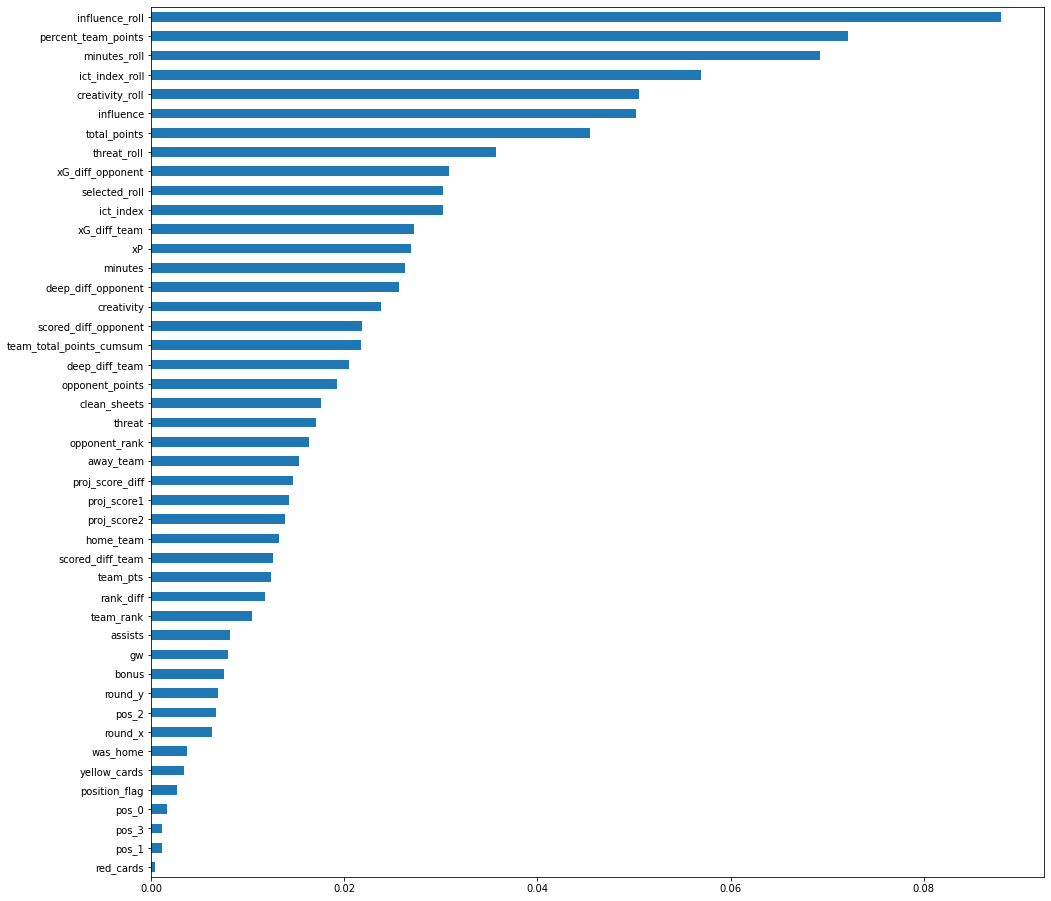

In [28]:

model = RandomForestClassifier(n_estimators=100,max_depth=7, random_state=0,min_samples_split=10)
model.fit(X_train,Y_train)#Fitting the model 
#Generating predictions from Random Fores Models
pred_rf=model.predict(X_test)
pred_rf_proba=model.predict_proba(X_test)

feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances=feat_importances.sort_values()
feat_importances.plot(kind='barh',figsize=(16,16))#Plotting feature importance

print('Model Accuracy')
print(model.score(X_test,Y_test))

Predicted    0    1  All
Actual                  
0          153  213  366
1           10   74   84
All        163  287  450


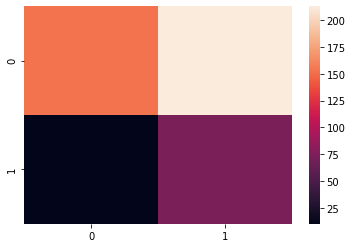

True Positive Rate [0.41803279 0.88095238]


In [29]:
#Confusion Matrix & True Positive Rate
calc_pred=pred_rf_proba[:,1]>0.16
calc_pred=calc_pred.astype(int)

conf_mat = confusion_matrix(Y_test, calc_pred)
df_confusion = pd.crosstab(Y_test, calc_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print (df_confusion)

#print(conf_mat)

# Visualize it as a heatmap
import seaborn
import matplotlib.pyplot as plt

seaborn.heatmap(conf_mat)
plt.show()

FP = conf_mat.sum(axis=0) - np.diag(conf_mat)  
FN = conf_mat.sum(axis=1) - np.diag(conf_mat)
TP = np.diag(conf_mat)
TN = conf_mat.sum() - (FP + FN + TP)
TPR = TP/(TP+FN)

print("True Positive Rate",TPR)

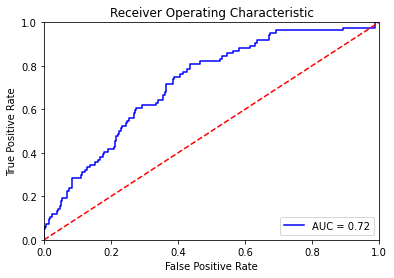

In [30]:
import sklearn.metrics as metrics

fpr, tpr, threshold = metrics.roc_curve(Y_test, pred_rf_proba[:,1])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [31]:
optimal_proba_cutoff = sorted(list(zip(np.abs(tpr - fpr), pred_rf_proba)), key=lambda i: i[0], reverse=True)[0][1]
print(optimal_proba_cutoff)

roc_predictions=calc_pred=pred_rf_proba[:,1]>0.26
roc_predictions=roc_predictions.astype(int)
#roc_predictions = [1 if i >= optimal_proba_cutoff else 0 for i in predicted_proba[:, -1]]

[0.93312984 0.06687016]


In [32]:
print("Accuracy Score Before and After Thresholding: {}, {}".format(accuracy_score(Y_test, roc_predictions), accuracy_score(Y_test, roc_predictions)))
print("Precision Score Before and After Thresholding: {}, {}".format(precision_score(Y_test, roc_predictions), precision_score(Y_test, roc_predictions)))
print("Recall Score Before and After Thresholding: {}, {}".format(recall_score(Y_test, roc_predictions), recall_score(Y_test, roc_predictions)))


Accuracy Score Before and After Thresholding: 0.6577777777777778, 0.6577777777777778
Precision Score Before and After Thresholding: 0.30113636363636365, 0.30113636363636365
Recall Score Before and After Thresholding: 0.6309523809523809, 0.6309523809523809


In [33]:
X_cols=weekly_data_subset_new_agg_pts_team2[['player_name','position','team','total_points','point_flag']].copy()
X_test_pred=pd.merge(X_test, X_cols, left_index=True, right_index=True)
X_test_pred['predictions']=pred_rf_proba[:,1]


In [34]:
X_test_pred.loc[X_test_pred['predictions']>0.5]

,round_x,was_home,home_team,away_team,proj_score1,proj_score2,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,red_cards,yellow_cards,xP,total_points_x,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,gw,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,rank_diff,proj_score_diff,round_y,team_total_points_cumsum,percent_team_points,position_flag,pos_0,pos_1,pos_2,pos_3,player_name,position,team,total_points_y,point_flag,predictions
1065,14,True,13,10,2.33,1.01,40.083333,45.941667,29.416667,11.558333,80.250000,2.128715e+06,0,2,95.4,85,14,3,5,963,481.0,551.3,353.0,138.7,23,4.0,0.069316,0.585799,0.536585,17,13,10.0,-0.142306,0.547619,0.478261,-6.0,1.32,13,507,0.167653,3,0,0,0,1,Bruno Miguel Borges Fernandes,MID,Man Utd,85,1,0.694884
1076,14,True,13,10,2.33,1.01,26.400000,22.150000,34.916667,8.350000,85.250000,5.036538e+05,0,1,58.8,66,4,3,4,1023,316.8,265.8,419.0,100.2,23,4.0,0.069316,0.585799,0.536585,17,13,10.0,-0.142306,0.547619,0.478261,-6.0,1.32,13,507,0.130178,3,0,0,0,1,Marcus Rashford,MID,Man Utd,66,0,0.632258
1372,14,True,7,1,1.45,1.31,34.753846,9.576923,56.692308,10.100000,88.230769,3.467450e+06,0,1,90.7,88,10,3,3,1147,451.8,124.5,737.0,131.3,23,4.0,0.313469,0.451429,0.560976,14,13,11.0,-0.128030,0.538043,0.407407,-7.0,0.14,13,558,0.157706,1,0,1,0,0,Dominic Calvert-Lewin,FWD,Everton,88,1,0.652129
1897,14,False,4,20,1.02,1.06,22.846154,29.815385,22.923077,7.576923,78.000000,1.665234e+05,0,0,59.9,64,6,4,3,1014,297.0,387.6,298.0,98.5,20,7.0,-0.399312,0.376712,0.433333,10,13,13.0,-0.697952,0.331325,0.250000,-6.0,-0.04,13,533,0.120075,3,0,0,0,1,Pedro Lomba Neto,MID,Wolves,64,0,0.566363
2218,14,False,6,11,1.00,2.05,39.338462,26.292308,53.384615,11.900000,80.384615,2.729300e+06,0,0,99.0,102,11,3,3,1045,511.4,341.8,694.0,154.7,28,1.0,0.631564,0.770833,0.604167,18,13,9.0,-0.074888,0.484848,0.513514,-8.0,-1.05,13,603,0.169154,3,0,0,0,1,Mohamed Salah,MID,Liverpool,102,1,0.763005
2403,14,False,18,2,1.05,1.72,23.500000,0.000000,0.000000,2.341667,82.500000,1.475374e+06,0,0,65.9,61,8,6,0,990,282.0,0.0,0.0,28.1,19,8.0,0.722783,0.580838,0.617647,7,13,15.0,-1.459169,0.322785,0.277778,-7.0,-0.67,13,572,0.106643,2,0,0,1,0,Emiliano Martínez,GK,Aston Villa,61,1,0.520477
2405,14,False,18,2,1.05,1.72,34.890909,41.654545,56.272727,13.263636,90.000000,2.059999e+06,0,3,74.5,76,8,6,6,990,383.8,458.2,619.0,145.9,19,8.0,0.722783,0.580838,0.617647,7,13,15.0,-1.459169,0.322785,0.277778,-7.0,-0.67,13,572,0.132867,3,0,0,0,1,Jack Grealish,MID,Aston Villa,76,1,0.722371
3485,14,True,14,8,1.33,1.16,25.866667,12.691667,30.083333,6.841667,80.583333,9.484025e+05,0,2,63.6,73,13,3,4,967,310.4,152.3,361.0,82.1,17,10.0,-0.368349,0.340426,0.432432,9,13,14.0,-0.462539,0.388158,0.352941,-4.0,0.17,13,448,0.162946,1,0,1,0,0,Callum Wilson,FWD,Newcastle,73,1,0.601178
4333,14,True,4,20,1.02,1.06,28.350000,0.000000,0.000000,2.833333,82.500000,8.371028e+05,0,0,44.8,64,14,5,0,990,340.2,0.0,0.0,34.0,10,13.0,-0.697952,0.331325,0.250000,20,13,7.0,-0.399312,0.376712,0.433333,6.0,-0.04,13,437,0.146453,2,0,0,1,0,Nick Pope,GK,Burnley,64,0,0.558529
4587,14,False,16,12,0.88,2.13,27.300000,43.783333,35.750000,10.691667,76.833333,1.829191e+06,0,0,72.8,60,9,4,6,922,327.6,525.4,429.0,128.3,20,7.0,0.865910,0.759494,0.600000,24,13,3.0,-0.029165,0.547945,0.581395,4.0,-1.25,13,568,0.105634,3,0,0,0,1,Kevin De Bruyne,MID,Man City,60,1,0.627369


In [35]:
from google.colab import files

X_test_pred.to_csv('df.csv')
#files.download('df.csv')


In [36]:
#Prepare dataset for future game week predictions
fixtures_df=fixtures_df[['event','team_h','team_a']]
max_week=weekly_data_subset['round'].max()
pred_data=weekly_data_subset.loc[weekly_data_subset['round']==max_week]
fixtures_df=fixtures_df.loc[fixtures_df['event']==max_week+1]

pred_data=pred_data[['player_name','position','team','team_id','round']].reset_index(drop=True)
pred_data
#fixtures_df

pred_data=pd.merge(left=pred_data,right=fixtures_df,left_on='team_id',right_on='team_h',how='left')
pred_data=pd.merge(left=pred_data,right=fixtures_df,left_on='team_id',right_on='team_a',how='left')

pred_data.loc[pred_data['team_h_x'].isna(),'team_h_x']=pred_data.loc[pred_data['team_h_x'].isna(),'team_h_y']
pred_data.loc[pred_data['team_a_x'].isna(),'team_a_x']=pred_data.loc[pred_data['team_a_x'].isna(),'team_a_y']
pred_data=pred_data[['player_name','position','team','team_id','team_h_x','team_a_x','round']]
pred_data=pred_data.rename(columns={"round": "gw","team_h_x": "home_team","team_a_x":"away_team"})

# #weekly_data_subset_new=weekly_data_subset[['player_name','gw','position','team','round','team_id','opponent_id','selected','was_home','home_team','away_team','proj_score1','proj_score2','point_flag']].copy()

# #Home Flag
pred_data['was_home']=0
pred_data.loc[pred_data['home_team']==pred_data['team_id'],'was_home']=1
pred_data['gw']=14

pred_data['opponent_id']=0

pred_data['opponent_id']=pred_data['home_team']
pred_data.loc[pred_data['was_home']==1,'opponent_id']=pred_data.loc[pred_data['was_home']==1,'away_team']
#pred_data

pred_data_roll=pd.merge(left=pred_data,right=weekly_rolling_means,left_on=['player_name','gw'],right_on=['player_name','gw'],how='inner')

# #Merge cumulative means
pred_data_roll_cum=pd.merge(left=pred_data_roll,right=gp_cumsum,left_on=['player_name','gw'],right_on=['player_name','gw'],how='inner')
#pred_data_roll_cum

# # #Merge team total ranking stats with home team
pred_data_roll_cum_team=pd.merge(left=pred_data_roll_cum,right=team_total_data_id,left_on=['team_id','gw'],right_on=['id','gw'])
pred_data_roll_cum_team=pred_data_roll_cum_team.rename(columns={"rank": "team_rank",'cum_pts':'team_pts','xG_diff':'xG_diff_team','scored_diff':'scored_diff_team','deep_diff':'deep_diff_team'})

# # #Merge team total ranking stats with away team
pred_data_roll_cum_team=pd.merge(left=pred_data_roll_cum_team,right=team_total_data_id,left_on=['opponent_id','gw'],right_on=['id','gw'])
pred_data_roll_cum_team=pred_data_roll_cum_team.rename(columns={"rank": "opponent_rank",'cum_pts':'opponent_points','xG_diff':'xG_diff_opponent','scored_diff':'scored_diff_opponent','deep_diff':'deep_diff_opponent'})
pred_data_roll_cum_team

# #Merge team total ranking stats with away team
pred_data_roll_cum_team_pts=pd.merge(left=pred_data_roll_cum_team,right=team_gp,left_on=['team_id','gw'],right_on=['team_id','round'],how='inner')
pred_data_roll_cum_team_pts['percent_team_points']=pred_data_roll_cum_team_pts['total_points']/pred_data_roll_cum_team_pts['team_total_points_cumsum']
pred_data_roll_cum_team_pts['gw']=max_week+1

pred_data_roll_cum_team_pts_spi=pd.merge(left=pred_data_roll_cum_team_pts,right=spi_data_name_fil,left_on=['home_team','away_team'],right_on=['home_id','away_id'],how='inner')

# #Calculate rank and projected score differences for the upcoming fixture
pred_data_roll_cum_team_pts_spi['rank_diff']=pred_data_roll_cum_team_pts_spi['team_rank']-pred_data_roll_cum_team_pts_spi['opponent_rank']
pred_data_roll_cum_team_pts_spi['proj_score_diff']=pred_data_roll_cum_team_pts_spi['proj_score1']-pred_data_roll_cum_team_pts_spi['proj_score2']

pred_data_roll_cum_team_pts_spi

,player_name,position,team,team_id,home_team,away_team,gw,was_home,opponent_id,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,red_cards,yellow_cards,xP,total_points,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,id_x,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,id_y,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,round,team_total_points_cumsum,percent_team_points,team1,team2,home_id,away_id,proj_score1,proj_score2,rank_diff,proj_score_diff
0,Aaron Connolly,FWD,Brighton,3,19.0,3.0,15,0,19.0,4.414286,4.242857,11.928571,2.050000,37.928571,40001.214286,0,0,22.5,25,2,1,1,531,61.8,59.4,167.0,28.7,12,3,14.0,0.347870,0.588957,0.421053,21,19,8.0,-0.046251,0.378698,0.525000,14,502,0.049801,West Ham United,Brighton and Hove Albion,19,3,1.45,1.17,6.0,0.28
1,Adam Lallana,MID,Brighton,3,19.0,3.0,15,0,19.0,5.228571,12.285714,8.357143,2.557143,49.857143,37218.071429,0,0,18.0,25,0,3,1,698,73.2,172.0,117.0,35.8,12,3,14.0,0.347870,0.588957,0.421053,21,19,8.0,-0.046251,0.378698,0.525000,14,502,0.049801,West Ham United,Brighton and Hove Albion,19,3,1.45,1.17,6.0,0.28
2,Adam Webster,DEF,Brighton,3,19.0,3.0,15,0,19.0,12.014286,4.007143,10.500000,2.650000,83.571429,147383.571429,0,1,25.9,31,0,3,0,1170,168.2,56.1,147.0,37.1,12,3,14.0,0.347870,0.588957,0.421053,21,19,8.0,-0.046251,0.378698,0.525000,14,502,0.061753,West Ham United,Brighton and Hove Albion,19,3,1.45,1.17,6.0,0.28
3,Alexis Mac Allister,MID,Brighton,3,19.0,3.0,15,0,19.0,3.242857,0.214286,1.071429,0.450000,4.357143,3447.571429,0,0,11.7,12,3,0,0,61,45.4,3.0,15.0,6.3,12,3,14.0,0.347870,0.588957,0.421053,21,19,8.0,-0.046251,0.378698,0.525000,14,502,0.023904,West Ham United,Brighton and Hove Albion,19,3,1.45,1.17,6.0,0.28
4,Alireza Jahanbakhsh,MID,Brighton,3,19.0,3.0,15,0,19.0,3.571429,6.242857,8.428571,1.821429,12.428571,3014.785714,0,1,5.8,11,0,0,1,174,50.0,87.4,118.0,25.5,12,3,14.0,0.347870,0.588957,0.421053,21,19,8.0,-0.046251,0.378698,0.525000,14,502,0.021912,West Ham United,Brighton and Hove Albion,19,3,1.45,1.17,6.0,0.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,Raphael Dias Belloli,MID,Leeds,10,10.0,4.0,15,1,4.0,14.180000,22.090000,26.600000,6.290000,59.400000,20874.900000,0,2,21.5,27,1,2,2,594,141.8,220.9,266.0,62.9,17,10,11.0,-0.356624,0.528634,0.444444,13,4,13.0,-0.663692,0.346591,0.296296,14,587,0.045997,Leeds United,Burnley,10,4,1.61,1.24,-2.0,0.37
446,Robin Koch,DEF,Leeds,10,10.0,4.0,15,1,4.0,12.571429,3.492857,6.357143,2.242857,64.857143,48685.000000,0,0,23.5,32,2,4,0,908,176.0,48.9,89.0,31.4,17,10,11.0,-0.356624,0.528634,0.444444,13,4,13.0,-0.663692,0.346591,0.296296,14,587,0.054514,Leeds United,Burnley,10,4,1.61,1.24,-2.0,0.37
447,Rodrigo Moreno,FWD,Leeds,10,10.0,4.0,15,1,4.0,9.400000,15.078571,24.500000,4.892857,44.500000,236757.000000,0,0,21.2,37,6,1,2,623,131.6,211.1,343.0,68.5,17,10,11.0,-0.356624,0.528634,0.444444,13,4,13.0,-0.663692,0.346591,0.296296,14,587,0.063032,Leeds United,Burnley,10,4,1.61,1.24,-2.0,0.37
448,Stuart Dallas,DEF,Leeds,10,10.0,4.0,15,1,4.0,22.600000,11.035714,15.928571,4.964286,89.285714,437378.714286,0,3,43.8,52,2,4,1,1250,316.4,154.5,223.0,69.5,17,10,11.0,-0.356624,0.528634,0.444444,13,4,13.0,-0.663692,0.346591,0.296296,14,587,0.088586,Leeds United,Burnley,10,4,1.61,1.24,-2.0,0.37


In [37]:
pred_data_roll_cum_team_pts_spi['position_flag'] = labelencoder.fit_transform(pred_data_roll_cum_team_pts_spi['position'])
cols = pd.get_dummies(pred_data_roll_cum_team_pts_spi['position_flag'])
cols.columns = ['pos_0','pos_1','pos_2','pos_3']
pred_data_roll_cum_team_pts_spi1 = pd.concat([pred_data_roll_cum_team_pts_spi, cols], axis=1)
pred_data_roll_cum_team_pts_spi1

pred_data_roll_cum_team_pts_spi1.drop(['player_name','position','team','team1','team2','away_id','home_id','id_x','id_y','opponent_id'],axis=1,inplace=True)

proba=model.predict_proba(pred_data_roll_cum_team_pts_spi1)
pred_data_roll_cum_team_pts_spi['predicted']=proba[:,1]

In [38]:
pred_data_roll_cum_team_pts_spi

,player_name,position,team,team_id,home_team,away_team,gw,was_home,opponent_id,influence_roll,creativity_roll,threat_roll,ict_index_roll,minutes_roll,selected_roll,red_cards,yellow_cards,xP,total_points,bonus,clean_sheets,assists,minutes,influence,creativity,threat,ict_index,team_pts,id_x,team_rank,xG_diff_team,deep_diff_team,scored_diff_team,opponent_points,id_y,opponent_rank,xG_diff_opponent,deep_diff_opponent,scored_diff_opponent,round,team_total_points_cumsum,percent_team_points,team1,team2,home_id,away_id,proj_score1,proj_score2,rank_diff,proj_score_diff,position_flag,predicted
0,Aaron Connolly,FWD,Brighton,3,19.0,3.0,15,0,19.0,4.414286,4.242857,11.928571,2.050000,37.928571,40001.214286,0,0,22.5,25,2,1,1,531,61.8,59.4,167.0,28.7,12,3,14.0,0.347870,0.588957,0.421053,21,19,8.0,-0.046251,0.378698,0.525000,14,502,0.049801,West Ham United,Brighton and Hove Albion,19,3,1.45,1.17,6.0,0.28,1,0.390785
1,Adam Lallana,MID,Brighton,3,19.0,3.0,15,0,19.0,5.228571,12.285714,8.357143,2.557143,49.857143,37218.071429,0,0,18.0,25,0,3,1,698,73.2,172.0,117.0,35.8,12,3,14.0,0.347870,0.588957,0.421053,21,19,8.0,-0.046251,0.378698,0.525000,14,502,0.049801,West Ham United,Brighton and Hove Albion,19,3,1.45,1.17,6.0,0.28,3,0.417715
2,Adam Webster,DEF,Brighton,3,19.0,3.0,15,0,19.0,12.014286,4.007143,10.500000,2.650000,83.571429,147383.571429,0,1,25.9,31,0,3,0,1170,168.2,56.1,147.0,37.1,12,3,14.0,0.347870,0.588957,0.421053,21,19,8.0,-0.046251,0.378698,0.525000,14,502,0.061753,West Ham United,Brighton and Hove Albion,19,3,1.45,1.17,6.0,0.28,0,0.393619
3,Alexis Mac Allister,MID,Brighton,3,19.0,3.0,15,0,19.0,3.242857,0.214286,1.071429,0.450000,4.357143,3447.571429,0,0,11.7,12,3,0,0,61,45.4,3.0,15.0,6.3,12,3,14.0,0.347870,0.588957,0.421053,21,19,8.0,-0.046251,0.378698,0.525000,14,502,0.023904,West Ham United,Brighton and Hove Albion,19,3,1.45,1.17,6.0,0.28,3,0.286410
4,Alireza Jahanbakhsh,MID,Brighton,3,19.0,3.0,15,0,19.0,3.571429,6.242857,8.428571,1.821429,12.428571,3014.785714,0,1,5.8,11,0,0,1,174,50.0,87.4,118.0,25.5,12,3,14.0,0.347870,0.588957,0.421053,21,19,8.0,-0.046251,0.378698,0.525000,14,502,0.021912,West Ham United,Brighton and Hove Albion,19,3,1.45,1.17,6.0,0.28,3,0.391130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,Raphael Dias Belloli,MID,Leeds,10,10.0,4.0,15,1,4.0,14.180000,22.090000,26.600000,6.290000,59.400000,20874.900000,0,2,21.5,27,1,2,2,594,141.8,220.9,266.0,62.9,17,10,11.0,-0.356624,0.528634,0.444444,13,4,13.0,-0.663692,0.346591,0.296296,14,587,0.045997,Leeds United,Burnley,10,4,1.61,1.24,-2.0,0.37,3,0.428206
446,Robin Koch,DEF,Leeds,10,10.0,4.0,15,1,4.0,12.571429,3.492857,6.357143,2.242857,64.857143,48685.000000,0,0,23.5,32,2,4,0,908,176.0,48.9,89.0,31.4,17,10,11.0,-0.356624,0.528634,0.444444,13,4,13.0,-0.663692,0.346591,0.296296,14,587,0.054514,Leeds United,Burnley,10,4,1.61,1.24,-2.0,0.37,0,0.355826
447,Rodrigo Moreno,FWD,Leeds,10,10.0,4.0,15,1,4.0,9.400000,15.078571,24.500000,4.892857,44.500000,236757.000000,0,0,21.2,37,6,1,2,623,131.6,211.1,343.0,68.5,17,10,11.0,-0.356624,0.528634,0.444444,13,4,13.0,-0.663692,0.346591,0.296296,14,587,0.063032,Leeds United,Burnley,10,4,1.61,1.24,-2.0,0.37,1,0.405285
448,Stuart Dallas,DEF,Leeds,10,10.0,4.0,15,1,4.0,22.600000,11.035714,15.928571,4.964286,89.285714,437378.714286,0,3,43.8,52,2,4,1,1250,316.4,154.5,223.0,69.5,17,10,11.0,-0.356624,0.528634,0.444444,13,4,13.0,-0.663692,0.346591,0.296296,14,587,0.088586,Leeds United,Burnley,10,4,1.61,1.24,-2.0,0.37,0,0.379371


In [39]:
pred_data_roll_cum_team_pts_spi.to_csv('pred.csv')
#files.download('pred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
pred_data_roll_cum_team_pts_spi.sort_values(by='predicted',ascending=False,inplace=True)

team_list=[]

gk=pred_data_roll_cum_team_pts_spi.loc[pred_data_roll_cum_team_pts_spi['position']=='GK','player_name'].head(1)
team_list.append(gk)
defender=pred_data_roll_cum_team_pts_spi.loc[pred_data_roll_cum_team_pts_spi['position']=='DEF','player_name'].head(3)
team_list.append(defender)
midfielder=pred_data_roll_cum_team_pts_spi.loc[pred_data_roll_cum_team_pts_spi['position']=='MID','player_name'].head(4)
team_list.append(midfielder)
forward=pred_data_roll_cum_team_pts_spi.loc[pred_data_roll_cum_team_pts_spi['position']=='FWD','player_name'].head(3)
team_list.append(forward)

team_list

[280    Emiliano Martínez
 Name: player_name, dtype: object, 22      Aaron Cresswell
 227    Andrew Robertson
 281    Ezri Konsa Ngoyo
 Name: player_name, dtype: object, 238       Mohamed Salah
 441       Mateusz Klich
 398     Kevin De Bruyne
 193    Pedro Lomba Neto
 Name: player_name, dtype: object, 243    Roberto Firmino
 291      Ollie Watkins
 210         Harry Kane
 Name: player_name, dtype: object]

In [62]:

flat_list = [item for sublist in team_list for item in sublist]
flat_list

output = pd.DataFrame({'Player_Name':flat_list})
output.to_csv('output.csv')
output


,Player_Name
0,Emiliano Martínez
1,Aaron Cresswell
2,Andrew Robertson
3,Ezri Konsa Ngoyo
4,Mohamed Salah
5,Mateusz Klich
6,Kevin De Bruyne
7,Pedro Lomba Neto
8,Roberto Firmino
9,Ollie Watkins


In [60]:
!git clone https://github.com/arpitsolanki/FPLBot
!git clone

Cloning into 'FPLBot'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 12 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [61]:
!ls

df.csv	FPLBot	pred.csv  sample_data
